<a href="https://colab.research.google.com/github/VictorWentz/projeto_dnc_amazon/blob/main/Projeto_Amazon_DNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto

O CEO da Amazon contratou um time de cientistas de dados 
para trabalhar em diferentes vertentes da empresa, e você 
ficou encarregado de fazer um sistema de recomendação para 
os clientes Amazon. Para isso, te deram acesso à uma base de 
dados não muito estruturada em Json: um arquivo de 
metadata com informações dos produtos e outro com as 
avaliações.

# Projeto

O CEO deseja que seu algoritmo de recomendação seja 
exclusivamente em cima de avaliações verificadas (campo 
`verified`=True no arquivo de avaliações). Contudo, há uma 
base sem classificação e que o CEO faz questão de que seja 
adicionada no sistema de recomendação (valores com missing 
value na coluna `verified`). Para isso, você precisará classificar 
se estas avaliações são verificadas ou não, e no caso positivo, 
adicioná-los no sistema de recomendação.
Adicionalmente, o CEO também deseja saber de possíveis 
associações e/ou correlações nesta base de dados que você vai 
trabalhar.


# Etapas

Desta forma, eis o que você deve fazer neste projeto:

- Carregar, limpar e fazer análises exploratórias no banco de 
dados fornecido;

- Classificar a base sem informação para incluir as observações 
das avaliações verificadas no sistema de recomendação;

- Desenvolver e entregar um sistema de recomendação, com 
exemplos de aplicação.

# Dados

[Link](https://bit.ly/3xzk1Tk) para download dos dados utilizados nesse projeto.

Criamos uma copia para nosso drive, e assim podemos carregar o drive no colab, para realizar as devidas importações.

In [ ]:
# /content/drive/MyDrive/Cópia de Video_Games_sample.json.gz
# /content/drive/MyDrive/Cópia de meta_Video_Games.json.gz

In [ ]:
!gunzip "/content/drive/MyDrive/Cópia de meta_Video_Games.json.gz"
!gunzip "/content/drive/MyDrive/Cópia de Video_Games_sample.json.gz"

In [1]:
sample_games_path = '/content/drive/MyDrive/Cópia de Video_Games_sample.json'
meta_video_games_path = '/content/drive/MyDrive/Cópia de meta_Video_Games.json'

# Bibliotecas

In [2]:
import pandas as pd

pd.options.display.max_rows=10
pd.options.display.float_format = '{:.3f}'.format


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import datetime

# EDA

O dataset Video_Games_sample, são dados de comentarios feitos nos produtos da amazon. É possivel identificar as colunas, de acordo com a imagem.
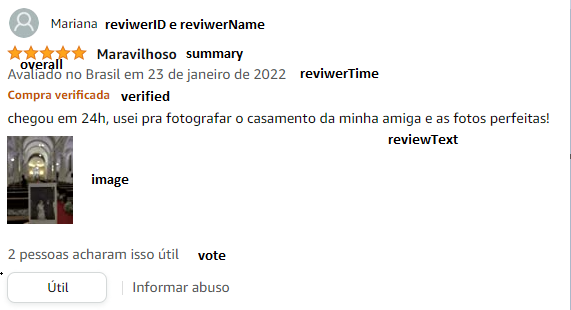


In [3]:
sample_games_df = pd.read_json(sample_games_path,lines=True)

meta_games_df = pd.read_json(meta_video_games_path, lines=True)

Temos que ter em mente, o nosso primeiro objetivo, que é realizar a classificação das linhas que possuem o `verified` igual a NaN, para isto, iremos primeiramente separar o dataset, em 2, um contendo apenas as linhas com NaN, e outro com valores `int64`.

In [ ]:
# Olhar as 5 primeiras linhas do sample_games_df
print(sample_games_df.shape)
display(sample_games_df.head())

(453562, 12)


,overall,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,verified,vote,image
0,1,"01 2, 2018",A16FEXIKAPT24U,B00000JRSB,{'Format:': ' Video Game'},Nicholas Sabin,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1514851200,NaN,NaN,NaN
1,5,"01 2, 2018",A3ISBEPYLY8IMO,B00000JRSB,{'Format:': ' Video Game'},Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.000,NaN,NaN
2,5,"12 21, 2017",A1RIUB1PZWLOVZ,B00000JRSB,{'Format:': ' Video Game'},Amazon Customer,I had a hard time finding this game locally or...,I am very pleased with this purchase,1513814400,1.000,NaN,NaN
3,5,"12 20, 2017",A2VY0K54SOCG0F,B00000JRSB,{'Format:': ' Video Game'},Oscentatious,This game is just as amazing as the first time...,This is the best deal for this game,1513728000,0.000,NaN,NaN
4,5,"12 19, 2017",A1ABJQ2REV14OQ,B00000JRSB,{'Format:': ' Video Game'},Thiago,"I bought as a gift for my friend, she is so ex...",Loved by lots of people,1513641600,1.000,NaN,NaN


In [4]:
verified_nan_df = sample_games_df[sample_games_df.verified.isnull()]
verified_nan_df.shape

(69016, 12)

In [5]:
verified_nan_df.to_csv('Video_games_sampled_to_predict.csv', index=False)

In [6]:
sample_games_df = sample_games_df[~sample_games_df.verified.isnull()]

In [ ]:
# Colunas do sample_games_df
sample_games_df.columns

Index(['overall', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'verified', 'vote', 'image'],
      dtype='object')

## Dicionario das variaveis, e seus valores

Agora que fizemos a separação do dataset, podemos nos concentrar agora em cada coluna e fazer os devidos tratamentos.

`overall`: Nota para da avaliação do produto

`reviewTime`: Data da publicação do review ( Mês / Dia / Ano )

`reviewerID`: Identificação do usuario, excluir.

`asin`: Identificação do produto. 

`style`: Categoria principal do produto.

`reviewerName`: identificação do usuario, excluir.

`reviewText`: Texto do review

`summary`: Sumario do texto

`unixReviewTime`: Excluir, mesma informação da coluna reviewTime

`verified`: Indica se o comentario é verificado ou não.

`vote`: Relevancia do comentario, quantidade de like que o comentario recebeu.

`image`: Caso a pessoa poste uma imagem junto com o comentario. o Url vai aparecer em uma lista.

In [ ]:
sample_games_df.head()

,overall,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,verified,vote,image
1,5,"01 2, 2018",A3ISBEPYLY8IMO,B00000JRSB,{'Format:': ' Video Game'},Jimmy,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1514851200,1.000,NaN,NaN
2,5,"12 21, 2017",A1RIUB1PZWLOVZ,B00000JRSB,{'Format:': ' Video Game'},Amazon Customer,I had a hard time finding this game locally or...,I am very pleased with this purchase,1513814400,1.000,NaN,NaN
3,5,"12 20, 2017",A2VY0K54SOCG0F,B00000JRSB,{'Format:': ' Video Game'},Oscentatious,This game is just as amazing as the first time...,This is the best deal for this game,1513728000,0.000,NaN,NaN
4,5,"12 19, 2017",A1ABJQ2REV14OQ,B00000JRSB,{'Format:': ' Video Game'},Thiago,"I bought as a gift for my friend, she is so ex...",Loved by lots of people,1513641600,1.000,NaN,NaN
5,5,"12 9, 2017",A368DF2G0T502X,B00000JRSB,{'Format:': ' Video Game'},Jonathan carter,"Looks good, some scratches on discs but plays.",Five Stars,1512777600,1.000,NaN,NaN


In [ ]:
sample_games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384546 entries, 1 to 453561
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         384546 non-null  int64  
 1   reviewTime      384546 non-null  object 
 2   reviewerID      384546 non-null  object 
 3   asin            384546 non-null  object 
 4   style           269703 non-null  object 
 5   reviewerName    384506 non-null  object 
 6   reviewText      384252 non-null  object 
 7   summary         384407 non-null  object 
 8   unixReviewTime  384546 non-null  int64  
 9   verified        384546 non-null  float64
 10  vote            48373 non-null   object 
 11  image           3907 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 38.1+ MB


In [ ]:
sample_games_df.drop(['reviewerID', 'reviewerName', 'unixReviewTime', 'image'],axis=1,inplace=True)

In [ ]:
sample_games_df['reviewTime'] = pd.to_datetime(sample_games_df['reviewTime'])

1        2018-01-02
2        2017-12-21
3        2017-12-20
4        2017-12-19
5        2017-12-09
            ...    
453556   2018-09-30
453557   2018-09-30
453558   2018-09-30
453559   2018-09-29
453561   2018-09-27
Name: reviewTime, Length: 384546, dtype: datetime64[ns]

## Coluna Style

Durante a limpeza desta coluna, encontramos que alguns valores na coluna, fugiam do formato de dicionario que esperavamos. Pois são valores ausentes.
Com o codigo abaixo, descobrimos que a coluna Style tem 13 sub itens em seus valores.

In [ ]:
keys = []
error_indices = []
for i, value in enumerate(sample_games_df['style'].values):
  try:
    keys.append(list(value.keys()))
  except AttributeError:
    error_indices.append(i)
 
  

In [ ]:
unique_values = []
for values in keys:
  unique_values.extend(values)

In [ ]:
set(unique_values)

{'Color:',
 'Configuration:',
 'Content:',
 'Edition:',
 'Format:',
 'Length:',
 'Package Quantity:',
 'Package Type:',
 'Pattern:',
 'Platform:',
 'Size:',
 'Style:',
 'Subscription Length:'}

In [ ]:
len(set(unique_values))

13

In [ ]:
sample_games_df.verified.value_counts()

1.000    314250
0.000     70296
Name: verified, dtype: int64

# 1° Parte Classificação

## Clean Dataset

In [18]:
sample_games_df.columns

Index(['overall', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'verified', 'vote', 'image'],
      dtype='object')

In [7]:
sample_clean = sample_games_df[['overall', 'reviewText', 'summary', 'verified', 'vote']]

In [8]:
sample_clean.dropna(subset=['reviewText', 'summary'], inplace=True)

In [9]:
sample_clean.fillna(value=0, inplace=True)

In [10]:
sample_clean.reset_index(inplace=True,drop=True)

In [11]:
index_error = []
for idx, values in enumerate(sample_clean.vote.values):
  try:
    p = int(values)

  except ValueError:
    index_error.append(idx)

In [30]:
len(index_error)

29

In [12]:
sample_clean.drop(index_error, inplace=True)

In [13]:
sample_clean['vote'] = sample_clean['vote'].astype('int64')

In [36]:
sample_clean['verified'].value_counts()

1.000    313859
0.000     70242
Name: verified, dtype: int64

In [37]:
display(sample_clean.describe(percentiles=[0.05,0.25,0.5,0.75,0.9,0.99]))

,overall,verified,vote
count,384101.000,384101.000,384101.000
mean,4.101,0.817,1.261
std,1.396,0.387,11.698
min,1.000,0.000,0.000
5%,1.000,0.000,0.000
...,...,...,...
50%,5.000,1.000,0.000
75%,5.000,1.000,0.000
90%,5.000,1.000,2.000
99%,5.000,1.000,19.000


In [39]:
# Vamos verificar a distruibuição do overall e vote, de acordo com os verified.
sample_clean.groupby('verified')['overall'].describe()

,count,mean,std,min,25%,50%,75%,max
verified,,,,,,,,
0.000,70242.000,3.621,1.632,1.000,2.000,4.000,5.000,5.000
1.000,313859.000,4.208,1.314,1.000,4.000,5.000,5.000,5.000


In [40]:
# Não iremos usar o vote como atributo, dropar
sample_clean.groupby('verified')['vote'].describe()

,count,mean,std,min,25%,50%,75%,max
verified,,,,,,,,
0.000,70242.000,4.099,21.828,0.000,0.000,0.000,3.000,855.000
1.000,313859.000,0.626,7.657,0.000,0.000,0.000,0.000,900.000


In [14]:
sample_clean.drop(['vote'], axis=1, inplace=True)

In [69]:
sample_clean.to_csv('Video_games_sampled_clean.csv', index=False)

## Classificação

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

In [16]:
X = sample_clean.drop(['verified'], axis=1)
y = sample_clean['verified']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    shuffle=True, random_state=42)

## Passo a Passo

In [18]:
#Vetorizar Summary
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii', max_features=5000)
smy_encoded_texts_train = vectorizer.fit_transform(X_train['summary'])

In [19]:
smy_encoded_texts_train.shape

(307280, 5000)

In [20]:
svd = TruncatedSVD(n_components=100)
smy_encoded_feature_train = svd.fit_transform(smy_encoded_texts_train)

In [21]:
smy_encoded_feature_train.shape

(307280, 100)

In [22]:
# Vetorizar reviewText
vectorizer_txt = TfidfVectorizer(stop_words='english', strip_accents='ascii', max_features=5000)
txt_encoded_texts_train = vectorizer_txt.fit_transform(X_train['reviewText'])
txt_encoded_texts_train.shape

(307280, 5000)

In [23]:
svd_txt = TruncatedSVD(n_components=100)
txt_encoded_feature_train = svd_txt.fit_transform(txt_encoded_texts_train)
txt_encoded_feature_train.shape

(307280, 100)

In [27]:
# Normalização do overall
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train['overall'].values.reshape(-1,1))
X_train_norm.shape

(307280, 1)

In [29]:
# Concatenação das features
X_train_concat = np.concatenate([X_train_norm, txt_encoded_feature_train, smy_encoded_feature_train],axis=1)

In [32]:
X_train_concat.shape

(307280, 201)

In [34]:
# Treinar modelo
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=300)

In [35]:
clf.fit(X_train_concat, y_train)

LogisticRegression(max_iter=300)

In [36]:
#Score no dataset de treino
clf.score(X_train_concat,y_train)

0.8421114293152825

In [37]:
# Dataset de teste.
# Summary
smy_encoded_texts_test = vectorizer.transform(X_test['summary'])
smy_encoded_feature_test = svd.transform(smy_encoded_texts_test)

# reviewText
txt_encoded_texts_test = vectorizer_txt.transform(X_test['reviewText'])
txt_encoded_feature_test = svd_txt.transform(txt_encoded_texts_test)

#Overall
X_test_norm = scaler.transform(X_test['overall'].values.reshape(-1,1))

#Concat
X_test_concat = np.concatenate([X_test_norm, txt_encoded_feature_test, smy_encoded_feature_test],axis=1)

In [38]:
# Score no dataset de teste
clf.score(X_test_concat, y_test)

0.8430377110425534

## Classificação das respostas com Valores Ausentes

In [62]:
unsee_path = '/content/Video_games_sampled_to_predict.csv'

In [67]:
unsee_df = pd.read_csv(unsee_path)

In [65]:
unsee_df.dropna(inplace=True)

In [59]:
unsee_df_clean = unsee_df[['overall', 'reviewText', 'summary']].copy()

In [50]:
# Dataset de teste.
# Summary
smy_unsee = vectorizer.transform(unsee_df_clean['summary'])
smy_unsee = svd.transform(smy_unsee)

# reviewText
txt_unsee = vectorizer_txt.transform(unsee_df_clean['reviewText'])
txt_unsee = svd_txt.transform(txt_unsee)

#Overall
ovr_unsee = scaler.transform(unsee_df_clean['overall'].values.reshape(-1,1))

#Concat
unsee_concat = np.concatenate([ovr_unsee, txt_unsee, smy_unsee],axis=1)

In [51]:
predicts = clf.predict(unsee_concat)

In [53]:
len(predicts)

68938

In [54]:
predicts.sum()

63523.0

## Criação do dataset para recomendação

In [86]:
sample_games_df.columns

Index(['overall', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'verified', 'vote', 'image'],
      dtype='object')

In [87]:
# Dataset Sample
clean_sample_path = '/content/Video_games_sampled_clean.csv'
unsee_sample_path = '/content/Video_games_sampled_to_predict.csv'

In [88]:
unsee_df_clean = pd.read_csv(unsee_sample_path, usecols=['asin', 'overall', 'reviewText', 'summary'])
unsee_df_clean.dropna(inplace=True)

In [89]:
unsee_df_clean['verified'] = predicts

In [90]:
clean_sample_df = pd.read_csv(clean_sample_path, usecols=['overall', 'reviewText', 'summary', 'verified'])

ValueError: ignored

In [73]:
clean_sample_df.head()

,overall,reviewText,summary,verified
0,5,Received this in perfect condition. Great rese...,Received this in perfect condition. Great rese...,1.000
1,5,I had a hard time finding this game locally or...,I am very pleased with this purchase,1.000
2,5,This game is just as amazing as the first time...,This is the best deal for this game,0.000
3,5,"I bought as a gift for my friend, she is so ex...",Loved by lots of people,1.000
4,5,"Looks good, some scratches on discs but plays.",Five Stars,1.000


In [81]:
unsee_df_clean.head()

,overall,reviewText,summary,verified
0,1,Game disc was cracked thats pretty lame,Game disc 1 was cracked,1.000
1,5,A classic!,Five Stars,1.000
2,5,The game is fantastic it works great,Five Stars,1.000
3,5,very good item,Five Stars,1.000
4,5,AWESOME SELLER LOVE THIS GAME ONE OF MY FAVORITES,Five Stars,1.000


In [82]:
df_recommendation = pd.concat([clean_sample_df, unsee_df_clean])

In [84]:
df_recommendation.to_csv('recommendation_df.csv', index=False)

In [83]:
df_recommendation.shape

(453039, 4)

# 2° Parte Sistema de Recomendação Content-Based

# TODO:
- Criar o sistema de recomendação:
 - Recomendar os 10 itens mais semelhantes.
 - Buscar o nome dos produtos na lista de produtos
 - Mostrar o resultado para o usuario

In [92]:
from sklearn.metrics.pairwise import cosine_similarity

In [91]:
recommendation_path = '/content/recommendation_df.csv'

In [93]:
df_rec = pd.read_csv(recommendation_path, usecols=['reviewText'])

In [94]:
df_rec.shape

(453039, 1)

In [95]:
class TextEncoderRecommender:

  def train(self, data):
    data = data.head(10000)
    self.vectorizer = TfidfVectorizer(stop_words="english", max_features=20000)
    self.X = self.vectorizer.fit_transform(data["reviewText"])
    self.sim_matrix = cosine_similarity(self.X)
    self.product_ids = data.index.tolist()

  def recommend(self, item: int):
    product_idx = self.product_ids.index(item)
    closest_10 = np.argsort(-self.sim_matrix[product_idx])[1:11]
    recommed = [self.product_ids[i] for i in closest_10]
    return recommed

In [97]:
systemRecommender = TextEncoderRecommender()

In [98]:
systemRecommender.train(df_rec)

In [105]:
idx_rec = systemRecommender.recommend(500)

In [106]:
df_rec.iloc[idx_rec]

,reviewText
2796,THE GAME IS NOT EVIL. IT IS WHAT YOU DO WITH T...
923,"When I bought this game three years ago, I was..."
480,"OK, i know this game is supposedly the best ga..."
220,"Just as my subtitle says,its a great game but ..."
850,"When it all boils down, there are two Final Fa..."
541,Final Fantasy VII is one of the greatest games...
437,...this is certainly one of the weakest games ...
363,Let me preface this by saying I am not a fan o...
322,"Final Fantasy 6, a.k.a. Final Fantasy 3 on the..."
359,For me this was my first Final Fantasy experie...


## Erro

In [62]:

#Vetorizar reviewText e summaray separados, e normalizar o overall

numeric_features = ['overall']
numeric_transform = Pipeline(
    steps=[('Scaler', StandardScaler())]
)

text_features = ['reviewText', 'summary']
text_transformer = Pipeline(
    steps=[
           ('tfidf', TfidfVectorizer()),
           ('svd', TruncatedSVD(algorithm='randomized', n_components=1))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
                  ('num', numeric_transform, numeric_features),
                  ('text', text_transformer, text_features)
    ]
)



In [63]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('trans', preprocessor),
    ('clf', LogisticRegression(max_iter=300, class_weight='balanced'))
])

In [64]:
from sklearn import set_config
set_config(display='diagram')
# with display='diagram', simply use display() to see the diagram
display(pipe)
# if desired, set display back to the default
set_config(display='text')

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  ['overall']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=1))]),
                                                  ['reviewText', 'summary'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=300))])

In [68]:
pipe.fit(X_train, y_train)

ValueError: ignored